# MESA session 4: solution notebook


In [1]:
import os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const


***
# 1. X-ray binaries

## •) 

We see the master `inlist` points to `inlist_project` for most controls, but to inlist1 for the plotting.

`inlist_project` contains some general binary mass transfer settings and sets the masses of the donor (star 1) and accretor/companion (star 2). 
 
 The **donor** is described in inlists with "1", i.e., `inlist1` and `inlist1_spec` 

Inlists with a "2" describe the **accretor** :
`inlist2` points to  `inlist2_spec` 

Becasue in `inlist_project`
'   evolve_both_stars = .false.', only star 1 (the donor) will be evolved (the other is treated as a point mass)

There is also `inlist_massive_defaults`, which details some general settings for massive stars.

## b) 

Kepler: 

$$
\frac{P^2}{(2\pi)^2} = \frac{a^3}{GM_{tot}}
$$


The Roche radius is approximately:

$$
R_{rl} = a \times 0.44 \frac{q^{0.33}}{(1 + q)^{0.22}}
$$

In [2]:
def kepler(m1, m2, P = None, a = None):
    """
    Given orbital period P return semi-major axis a 
    Given semi-major axis a and total mass Mtot 
    values are assumed to be delivered with units
    """
    m1 = m1.to(u.kg)
    m2 = m2.to(u.kg)
    Mtot = m1 + m2

    if P is not None:
        P = P.to(u.s)
        a = (const.G * Mtot * (P / (2*np.pi))**2) ** (1/3)
        return a.to(u.Rsun)

    if a is not None:
        a = a.to(u.m)
        P = 2*np.pi * np.sqrt(a**3 / (const.G * Mtot))
        return P.to(u.days)


def roche_radius(a, q):
    """
    a Orbital separation.
    q : M_donor / M_accretor.
    -------
    Rrl : Roche radius in same units as a.
    """
    return a * 0.44 * q**0.33 / (1 + q)**0.22


In [3]:
M1 = 12.3*u.Msun # donor
M2 = 4.3*u.Msun # donor

a = kepler(M1, M2, P = 13*u.day, a = None)
print(f'Semi major axis of system {a}')

print(f"This means that the Roche radius of the donor is {roche_radius(a, M1/M2)}")



Semi major axis of system 59.35209523699168 solRad
This means that the Roche radius of the donor is 27.44429688280183 solRad


We know from previous MESA sessions that 15Msun stars get to about 10 solar radii by the end of its main-sequence ( < case A), but has reached hundreds (to almost a 1000) solar radi at the tip of the giant branch when He ignites (> case C). 
Since the stars roche radius is somewhere in between at about 30Rsun, the we expect the star to experience case B mass transfer.

Let's reuse our HR diagram plotter from last time: 

In [4]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None),
               VMIN=-3, VMAX=0, cmap_name = 'rainbow', 
               colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.

    """

    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(0.5, 5.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)
            #   manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        C        = np.asarray(getattr(hist, colour_by))[start:]

        scat = ax.scatter(log_Teff, log_L, c=C, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], log_L[0], marker='*', s=50)
        ax.text(log_Teff[0],  log_L[0] , f"${np.round(hist.star_mass[0], 1)}$"+"M$_{\odot}$",
                 ha='right', va='top', fontsize = 15) #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()

    os.makedirs(save_loc, exist_ok=True)
    out = os.path.join(save_loc, f"HR_{colour_by}.png")
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    return 


## HR diagram

In [5]:
# donor_history.bulk_names


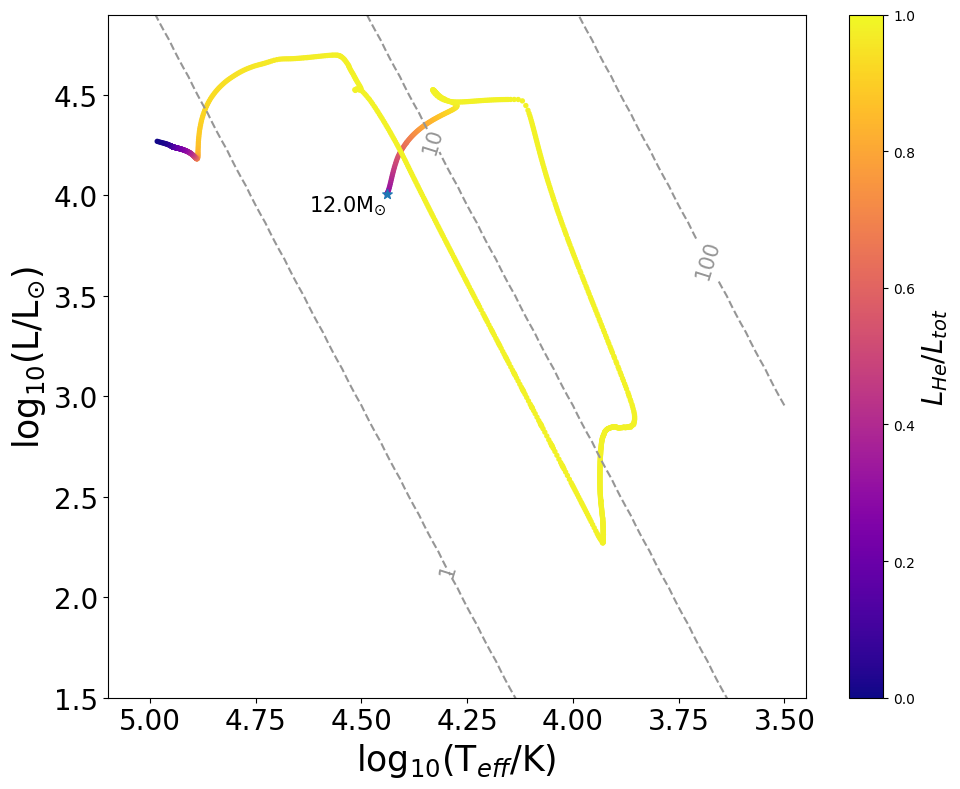

In [7]:
# Load your computed models
donor_history = mr.MesaData('./data/session4_work/LOGS1/history.data')


HR_diagram([donor_history],
           xlim=(3.45, 5.1), ylim=(1.5, 4.9),
           VMIN=0, VMAX=1, cmap_name = 'plasma',
           colour_by='center_he4', colour_label='$L_{He}$/$L_{tot}$')


## 3a ) 
We see that the star indeed starts RLOF post while on the Hertszprung gap. 
From that point onwards it is very different from 'normal' single stellar evolution. 
The star plummets to low luminosities, this is caused by the strong thermal disequilibrium of the primary: a radiative donor star shrinks in response to mass loss and has to re-expand to regain thermal equilibrium. This requiresthe absorption of gravitational energy, so that the surface luminosity during thermal-timescale mass transfer is (much) smaller than the nuclear luminosity provided by the H-burning shell.


The star stops mass transferring when essentially the whole envelope is lost, when the mass transfer nears the core, it no longer responds to mass loss as a radiative envelope. We see from the colours that He ignition starts not much later. 

The star is very luminour and hot post mass transfer: it looks like a stripped He star!



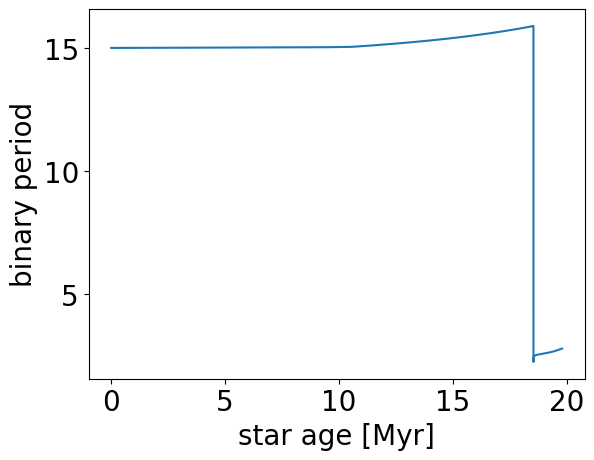

In [50]:
binary_history = mr.MesaData('./data/session4_work/binary_history.data')

binary_history.bulk_names

plt.plot(binary_history.age/1e6, binary_history.period_days)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('binary period',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.show()

We see that the binary orbit shrinks during mass transfer

In [46]:
# donor_history.bulk_names
binary_history.bulk_names


('model_number',
 'age',
 'period_days',
 'binary_separation',
 'v_orb_1',
 'v_orb_2',
 'rl_1',
 'rl_2',
 'rl_relative_overflow_1',
 'rl_relative_overflow_2',
 'star_1_mass',
 'star_2_mass',
 'lg_mtransfer_rate',
 'lg_mstar_dot_1',
 'lg_mstar_dot_2',
 'lg_system_mdot_1',
 'lg_system_mdot_2',
 'lg_wind_mdot_1',
 'lg_wind_mdot_2',
 'eff_xfer_fraction',
 'J_orb',
 'Jdot',
 'jdot_mb',
 'jdot_gr',
 'jdot_ml',
 'jdot_ls',
 'jdot_missing_wind',
 'extra_jdot',
 'donor_index',
 'point_mass_index')

10336.375266350873 m 1.4857517991017497e-05 solRad


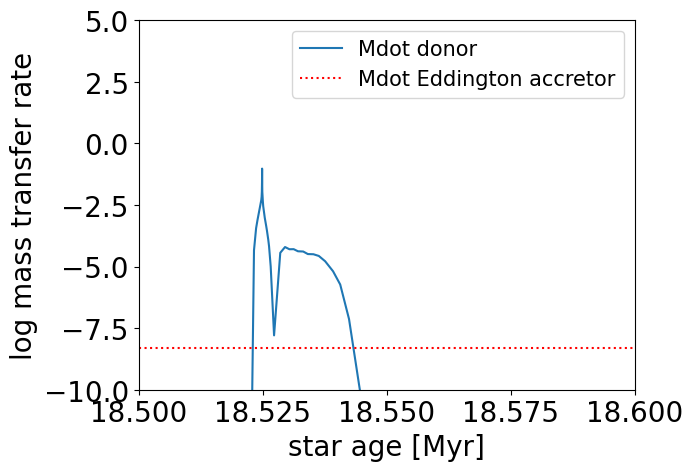

In [86]:

# Mdot donor
plt.plot(binary_history.age/1e6, binary_history.lg_mtransfer_rate, label = 'Mdot donor')

# Assuming Racc is the schwarschild radius
Mbh = 3.5*u.Msun
Mbh_kg = Mbh.to(u.kg)
Rsch = 2 * const.G * Mbh_kg / const.c**2
Rsch_msun = Rsch.to(u.Rsun)
print(Rsch, Rsch_msun)
Mdot_edd = 3.3 * 10**-4 * Rsch_msun.value

plt.axhline(np.log10(Mdot_edd), label = 'Mdot Eddington accretor', c= 'r', ls = ":")

plt.xlim(18.5,18.6)
plt.ylim(-10,5)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)

plt.show()

The donors mass transfer rate much exceeds the eddington accretion rate

In [89]:
# donor_history.bulk_names

binary_history.bulk_names

('model_number',
 'age',
 'period_days',
 'binary_separation',
 'v_orb_1',
 'v_orb_2',
 'rl_1',
 'rl_2',
 'rl_relative_overflow_1',
 'rl_relative_overflow_2',
 'star_1_mass',
 'star_2_mass',
 'lg_mtransfer_rate',
 'lg_mstar_dot_1',
 'lg_mstar_dot_2',
 'lg_system_mdot_1',
 'lg_system_mdot_2',
 'lg_wind_mdot_1',
 'lg_wind_mdot_2',
 'eff_xfer_fraction',
 'J_orb',
 'Jdot',
 'jdot_mb',
 'jdot_gr',
 'jdot_ml',
 'jdot_ls',
 'jdot_missing_wind',
 'extra_jdot',
 'donor_index',
 'point_mass_index')

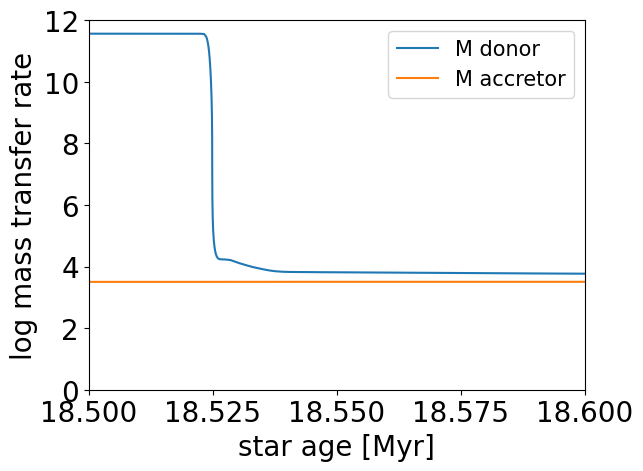

Delta accretor mass 0.0036629027663295233
Delta donor mass -8.610654193514645
Fractional accretion 0.04253919253996219 %


In [100]:
# How much mass did the donor star lose? 
# What fraction of this mass is accreted by the black hole and how much is lost from the system?


# Donor mass
plt.plot(binary_history.age/1e6, binary_history.star_1_mass, label = 'M donor')
plt.plot(binary_history.age/1e6, binary_history.star_2_mass, label = 'M accretor')

plt.xlim(18.5,18.6)
plt.ylim(0,12)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)
plt.show()

dma = binary_history.star_2_mass[-1] - binary_history.star_2_mass[0]
dmd = binary_history.star_1_mass[-1] - binary_history.star_1_mass[0]
print(f"Delta accretor mass {dma}")
print(f"Delta donor mass {dmd}")
print(f"Fractional accretion {dma / abs(dmd) *100 } %")


We see that while the donor has lost 8 solar masses, the accretor has barely accreted anything. 

# 4. Future evolution? 

In [105]:
Mbh1 = binary_history.star_1_mass[-1]
Mbh2 = binary_history.star_2_mass[-1]
print(f" Donor mass at end of simulation {Mbh1}" )


 Donor mass at end of simulation 3.389344512779557


## a) 

we have a BBH system with the accretor still being about 3.5Msun, and the donor now being very similar in mass about 3.4Msun.


In [110]:
# Final separation
# binary_history.period_days[-1]
afinal =  binary_history.binary_separation[-1] # in Rsun


In [131]:
def tau_merge(a_Rsun, M1_Msun, M2_Msun):
    """
    tau = 1.503e8 yr * [1/(q(1+q))] * (a/Rsun)^4 * (M1/Msun)^(-3)

    ----------
    a  : separation assumed in Rsun
    M1 : primary mass assumed in in Msun
    """
    # Note that the actual peters formula is symmetric in mass, so it doesnt matter wchich is BH1 or 2
    q = M2_Msun/M1_Msun

    tau_yr = 1.503e8 * (1.0 / (q * (1.0 + q))) * (a_Rsun**4) * (M1_Msun**-3)
    return tau_yr 

print(f"Merger timescale = {tau_merge(afinal, Mbh2, Mbh1)*1e-9} Gyr ")


Merger timescale = 114.11613329690832 Gyr 


LVK will never see this! This is longer than the age of the universe. 

# 3. Simultanious evolution of two massive stars

## a) 

We see that the more massive star runs out of hydrogen first, which is what we expect since the nuclear timescale scales with mass to 
$$
\tau_{nuc} \propto 10^{10} \frac{M}{M_{\odot}} \frac{L_{\odot}}{L} \propto M^{-2.8}
$$
given the mass luminosity relation $L\propto M^{3.8}$.

The surface abundance doesn't change for most of the evolution since the envelope is still made of unprocecced material. Only when the donor star is fully stripped will its surface abundance change (become more He enriched).

In [ ]:
binary_history.bulk_names

('model_number',
 'age',
 'period_days',
 'binary_separation',
 'v_orb_1',
 'v_orb_2',
 'rl_1',
 'rl_2',
 'rl_relative_overflow_1',
 'rl_relative_overflow_2',
 'star_1_mass',
 'star_2_mass',
 'lg_mtransfer_rate',
 'lg_mstar_dot_1',
 'lg_mstar_dot_2',
 'lg_system_mdot_1',
 'lg_system_mdot_2',
 'lg_wind_mdot_1',
 'lg_wind_mdot_2',
 'eff_xfer_fraction',
 'J_orb',
 'Jdot',
 'jdot_mb',
 'jdot_gr',
 'jdot_ml',
 'jdot_ls',
 'jdot_missing_wind',
 'extra_jdot',
 'donor_index',
 'point_mass_index')

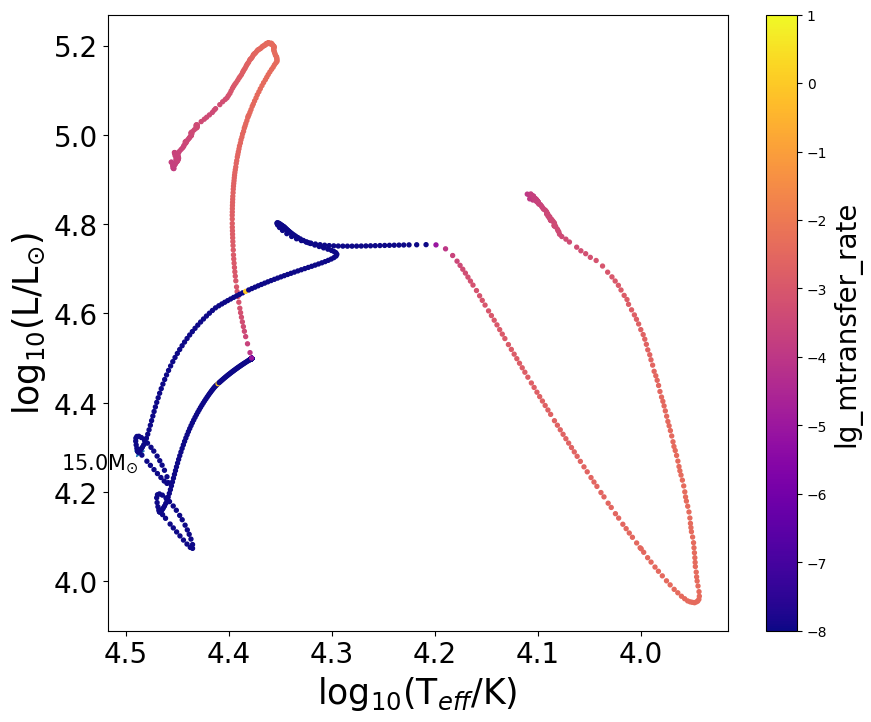

In [ ]:
donor_history = mr.MesaData('./data/session4_work_2/LOGS1/history.data')
accretor_history = mr.MesaData('./data/session4_work_2/LOGS2/history.data')

fig, ax = plt.subplots(figsize=(10, 8))

# Annotate the mass of the star at the start of the MS
ax.scatter(donor_history.log_Teff[0], donor_history.log_L[0], marker='*', s=50)
ax.text(donor_history.log_Teff[0],  donor_history.log_L[0] , f"${np.round(donor_history.star_mass[0], 1)}$"+"M$_{\odot}$",
            ha='right', va='top', fontsize = 15) #log_Teff

VMIN=-8
VMAX=1
cmap_name = 'plasma'

# Accretor
scat = ax.scatter(accretor_history.log_Teff, accretor_history.log_L, 
c=accretor_history.lg_mtransfer_rate, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

#Donor
scat = ax.scatter(donor_history.log_Teff, donor_history.log_L, c= donor_history.lg_mtransfer_rate, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8  )

cb = plt.colorbar(scat, ax=ax)
cb.set_label('lg_mtransfer_rate', fontsize=20)

# -- Plot values -- 
ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ax.invert_xaxis()

plt.show()


## b) 

The donor star behaves similar as in the previous exercise. 
the thermal timescale of the secondary is longer than that of the donor, so the accretor is brought out of thermal equilibrium, and accretion onto a star with a radiative envelope causes it to expand (which is what we see). 
The main effect of accretion is the compression of underlying layers which releases gravitational energy, and causing the star to become brighter due to the accretion.

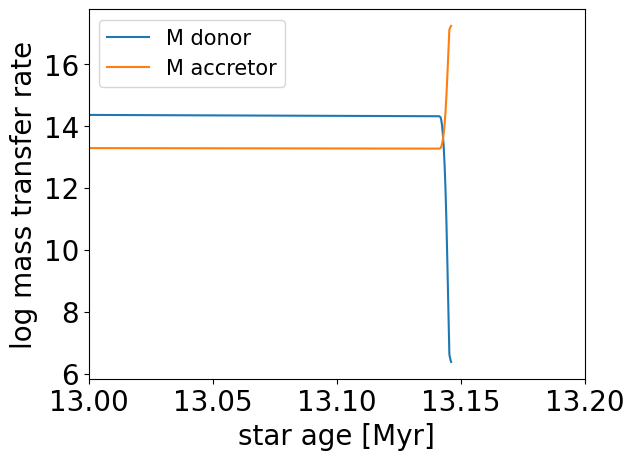

Delta accretor mass 3.718199757158187
Delta donor mass -8.625497091136863
Fractional accretion 0.431070779790631


In [139]:
binary_history_2 = mr.MesaData('./data/session4_work_2/binary_history.data')


# Donor mass
plt.plot(binary_history_2.age/1e6, binary_history_2.star_1_mass, label = 'M donor')
plt.plot(binary_history_2.age/1e6, binary_history_2.star_2_mass, label = 'M accretor')

plt.xlim(13.0,13.2)
# plt.ylim(0,12)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)
plt.show()

dma = binary_history_2.star_2_mass[-1] - binary_history_2.star_2_mass[0]
dmd = binary_history_2.star_1_mass[-1] - binary_history_2.star_1_mass[0]
print(f"Delta accretor mass {dma}")
print(f"Delta donor mass {dmd}")
print(f"Fractional accretion {dma / abs(dmd)}")


data/session4_work_2/LOGS1 ['data/session4_work_2/LOGS1']
Reading profile data
Reading history data
Constructing mixing regions
there are 10 mixing zones
data/session4_work_2/LOGS2 ['data/session4_work_2/LOGS2']
Reading profile data
Reading history data
Constructing mixing regions
there are 10 mixing zones


Kipp_Plot(contour_plot=<matplotlib.contour.QuadContourSet object at 0x15550c91a290>, histories=[<mesa_data.mesa_data object at 0x155529122b30>], xlims=(1.0, 841.0))

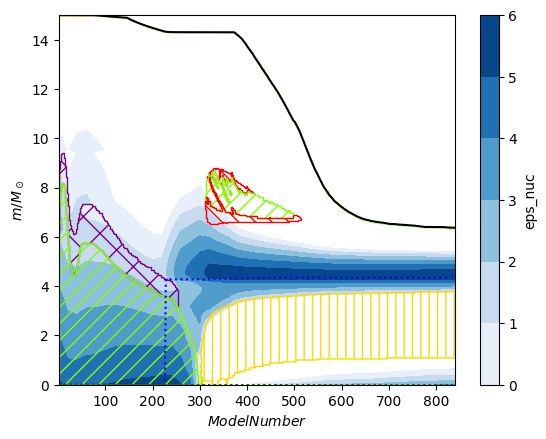

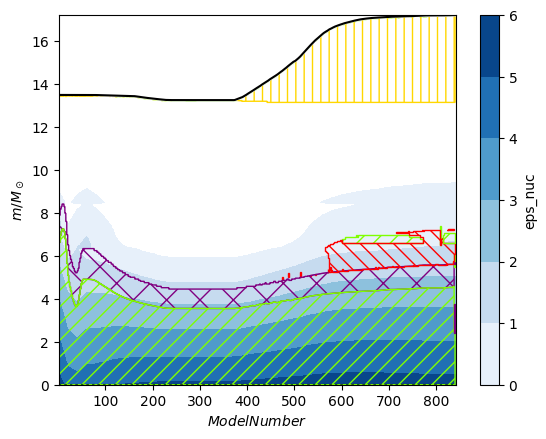

In [142]:
import sys
import os
sys.path.append(os.path.expanduser("~/Programs/mkipp"))

import mkipp
import kipp_data
import mesa_data

# Donor Kippenhahn
mkipp.kipp_plot(mkipp.Kipp_Args(logs_dirs = ['data/session4_work_2/LOGS1'], save_filename = "plots/Kippenhahn.png",))

# Accretor Kippenhahn
mkipp.kipp_plot(mkipp.Kipp_Args(logs_dirs = ['data/session4_work_2/LOGS2'], save_filename = "plots/Kippenhahn.png",))


The convective core of the secondary grows a bit due to accretion. 
There will be more fresh hydrogen mixed into the accretors core. 

This is indeed rejuvination: the star now has more fresh fuel available and will be able to live longer than if it hadn't accreted. 

This process is indeed a possible solution to 'blue stragglers', i.e. stars that are to hot for the turn-off of their cluster population (based on simple single-star evolution, you would have expected these stars to have already evolved off the main-sequence.)
 